In [6]:
from gerrychain import (Graph, GeographicPartition, Election, updaters)
import numpy as np
from sklearn.linear_model import LinearRegression

natlDemVote = {"PRES12": 51.964, "PRES16": 51.113, "HOUSE18": 54.379, "PRES20": 52.294}

# some states do not have 2016 results
# NC has multiple assignments: oldplan (2011), newplan (2016), judge (2017)
dem_field_pres16 = {'GA': 'PRES16D', 'MI': 'PRES16D', 'MN': 'PRES16D', 'NC': 'EL16G_PR_D', 'OH': 'PRES16D',
                    'OR': 'PRES16D', 'PA': 'T16PRESD', 'TX': 'PRES16D', 'VA': 'G16DPRS', 'WI': 'PREDEM16'}
gop_field_pres16 = {'GA': 'PRES16R', 'MI': 'PRES16R', 'MN': 'PRES16R', 'NC': 'EL16G_PR_R', 'OH': 'PRES16R',
                    'OR': 'PRES16R', 'PA': 'T16PRESR', 'TX': 'PRES16R', 'VA': 'G16RPRS', 'WI': 'PREREP16'}
dem_field_gov18 = {'AZ': 'GOV18D', 'CO': 'GOV18D', 'MI': 'GOV18D', 'OR': 'GOV18D'}
gop_field_gov18 = {'AZ': 'GOV18R', 'CO': 'GOV18R', 'MI': 'GOV18R', 'OR': 'GOV18R'}
dem_field_house18 = {'AZ': 'USH18D', 'CO': 'USH18D', 'OR': 'USH18D'}
gop_field_house18 = {'AZ': 'USH18R', 'CO': 'USH18R', 'OR': 'USH18R'}
pop_field = {'AZ': 'TOTPOP', 'CO': 'TOTPOP', 'GA': 'TOTPOP', 'MI': 'TOTPOP', 'MN': 'TOTPOP', 'NC': 'TOTPOP',
             'OH': 'TOTPOP', 'OR': 'TOTPOP', 'PA': 'TOTPOP', 'TX': 'TOTPOP', 'VA': 'TOTPOP', 'WI': 'PERSONS'}
assignment_field = {'AZ': 'CD', 'CO': 'CD116FP', 'GA': 'CD', 'MI': 'CD', 'MN': 'CONGDIST', 'NC': 'newplan',
                    'OH': 'CD', 'OR': 'CD', 'PA': 'CD_2011', 'TX': 'USCD', 'VA': 'CD_16', 'WI': 'CON'}
projection_code = {'AZ': '2223', 'CO': '2957', 'GA': '4019', 'MI': '6493', 'MN': '26915', 'NC': '6543',
                   'OH': '3747', 'OR': '2338', 'PA': '26918', 'TX': '3081', 'VA': '3968', 'WI': '26916'}
county_field = {'AZ': 'COUNTY', 'CO': 'COUNTYFP', 'GA': 'CTYNAME', 'MI': 'county_nam', 'MN': 'COUNTYNAME', 'NC': 'County',
                'OH': 'COUNTY', 'OR': 'County', 'PA': 'COUNTYFP10', 'TX': 'COUNTY', 'VA': 'locality', 'WI': 'CNTY_NAME'}

STATE = 'GA'

YEAR = "2011"

ELECTION_USED = "PRES16"

DEM_VOTE, GOP_VOTE = 0, 0
if ELECTION_USED == "PRES16":
    DEM_VOTE = dem_field_pres16[STATE]
    GOP_VOTE = gop_field_pres16[STATE]
elif ELECTION_USED == "GOV18":
    DEM_VOTE = dem_field_gov18[STATE]
    GOP_VOTE = gop_field_gov18[STATE]
elif ELECTION_USED == "HOUSE18":
    DEM_VOTE = dem_field_house18[STATE]
    GOP_VOTE = gop_field_house18[STATE]
POP_FIELD_NAME = pop_field[STATE]
COUNTY_FIELD_NAME = county_field[STATE]
ASSIGNMENT = assignment_field[STATE]

graph = Graph.from_json(''.join([STATE, YEAR, '/', STATE, '_VTDs.json']))

elections = []
elections.append(Election(ELECTION_USED, {"Democratic": DEM_VOTE, "Republican": GOP_VOTE}))

# Population updater, for computing how close to equality the district
# populations are. POP_FIELD_NAME is the population column from our shapefile.
my_updaters = {"population": updaters.Tally(POP_FIELD_NAME, alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

partition = GeographicPartition(graph, assignment=ASSIGNMENT, updaters=my_updaters)

WHITE_POP = "NH_WHITE"
BLACK_POP = "NH_BLACK"
HISP_POP = "HISP"
ASIAN_POP = "NH_ASIAN"
#everyone else is "other" - all of these get subtracted from POP_FIELD_NAME


In [7]:
turnout_by_race_dict = {}
too_small_const = 0.05 # min pct of voters in a block
pop_by_race_dict = {}
for node in graph:
    totpop = graph.nodes[node][POP_FIELD_NAME]
    if totpop==0:
        pop_by_race_dict[node] = (0,0,0,0,0) # no one lives here
        continue
    white, black, hisp, asian = graph.nodes[node][WHITE_POP], graph.nodes[node][BLACK_POP], graph.nodes[node][HISP_POP], graph.nodes[node][ASIAN_POP]
    other = totpop - white - black - hisp - asian
    if white/totpop < too_small_const:
        white = 0
        other += white
    if black/totpop < too_small_const:
        black = 0
        other += black
    if hisp/totpop < too_small_const:
        hisp = 0
        other += hisp
    if asian/totpop < too_small_const:
        asian = 0
        other += asian
    pop_by_race_dict[node] = (white/totpop, black/totpop, hisp/totpop, asian/totpop, other/totpop)

In [9]:
races = 5
for node in range(5):
    if graph.nodes[node][POP_FIELD_NAME] == 0: continue 
    votes = graph.nodes[node][DEM_VOTE] + graph.nodes[node][GOP_VOTE]
    turnout = {node: votes/graph.nodes[node][POP_FIELD_NAME]}
    nbrs = {nbr for nbr, datadict in graph.adj[node].items()}
    deg2turnout = {} # weighted half as much
    x, y = [], []
    for nbr in nbrs:
        if graph.nodes[nbr][POP_FIELD_NAME] == 0: continue
        nbrVotes = graph.nodes[nbr][DEM_VOTE] + graph.nodes[nbr][GOP_VOTE]
        turnout[nbr] = nbrVotes/graph.nodes[nbr][POP_FIELD_NAME]
        # for deg2nbr, datadict in graph.adj[nbr].items():
        #     if deg2nbr not in deg2turnout and deg2nbr not in nbrs and deg2nbr != node:
        #         deg2Votes = graph.nodes(deg2nbr)[DEM_VOTE] + graph.nodes[nbr][GOP_VOTE]
        #         deg2turnout[deg2nbr] = deg2Votes/graph.nodes[deg2nbr][POP_FIELD_NAME]
    for node in turnout:
        x.append([*pop_by_race_dict[node]])
        y.append(turnout[node])
    reg = LinearRegression()
    reg.fit(x, y)
    print(reg.predict(np.array([[1,0,0,0,0]])), reg.predict(np.array([[0.5,0.5,0,0,0]])), reg.predict(np.array([[0,1,0,0,0]])))

[0.96288574] [0.99050979] [1.01813384]
[2.75300437] [8.86855286] [14.98410134]
[1.10213012] [0.81334983] [0.52456954]
[2.83184995] [9.36595922] [15.90006848]
[0.0344705] [-3.59908674] [-7.23264397]


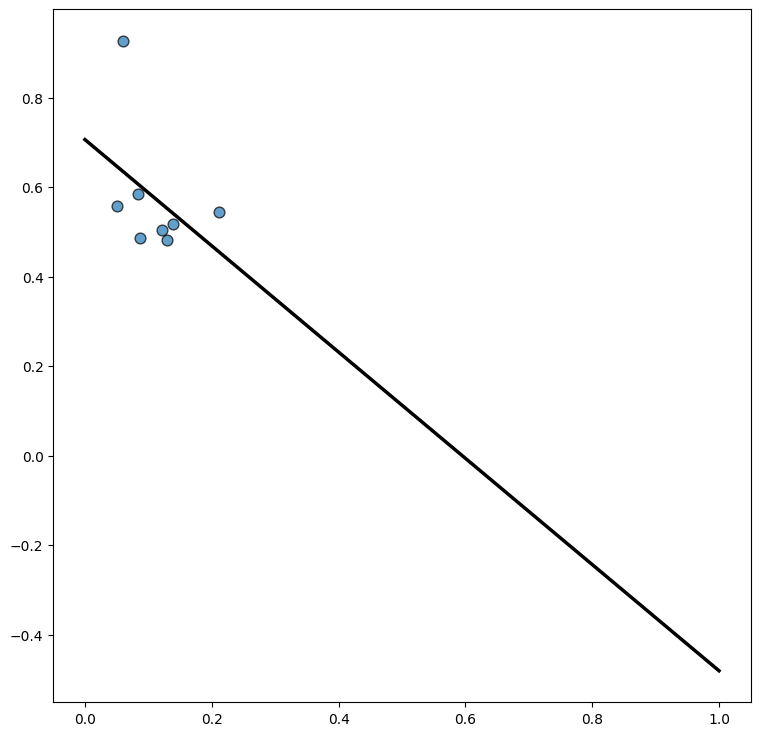

In [18]:
races = 5
node = 0
import matplotlib.pyplot as plt
votes = graph.nodes[node][DEM_VOTE] + graph.nodes[node][GOP_VOTE]
turnout = {node: votes/graph.nodes[node][POP_FIELD_NAME]}
nbrs = {nbr for nbr, datadict in graph.adj[node].items()}
deg2turnout = {} # weighted half as much
x, y = [], []
for nbr in nbrs:
    if graph.nodes[nbr][POP_FIELD_NAME] == 0: continue
    nbrVotes = graph.nodes[nbr][DEM_VOTE] + graph.nodes[nbr][GOP_VOTE]
    turnout[nbr] = nbrVotes/graph.nodes[nbr][POP_FIELD_NAME]
    # for deg2nbr, datadict in graph.adj[nbr].items():
    #     if deg2nbr not in deg2turnout and deg2nbr not in nbrs and deg2nbr != node:
    #         deg2Votes = graph.nodes(deg2nbr)[DEM_VOTE] + graph.nodes[nbr][GOP_VOTE]
    #         deg2turnout[deg2nbr] = deg2Votes/graph.nodes[deg2nbr][POP_FIELD_NAME]
for node1 in turnout:
    x.append(pop_by_race_dict[node1][1])
    y.append(turnout[node1])


fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, 1, num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

plt.show()